In [1]:
from six.moves import xrange
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm

from model import VQVAE, _cifar10_arch, PixelCNN
from cifar10 import get_image

DATA_DIR = 'datasets/cifar10'
MODEL,K,D = \
    ('models/cifar10/last.ckpt',
     10,
     256)
PIXELCNN_MODEL,NUM_LAYERS,NUM_FEATURE_MAPS = \
    ('models/cifar10/last-pixelcnn.ckpt',
     12,
     64)

image,_ = get_image(True,num_epochs=None)
images = tf.train.shuffle_batch(
    [image],
    batch_size=100,
    num_threads=1,
    capacity=100*2,
    min_after_dequeue=100)


valid_image,_ = get_image(False,num_epochs=None)
valid_images = tf.train.shuffle_batch(
    [valid_image],
    batch_size=100,
    num_threads=1,
    capacity=100*2,
    min_after_dequeue=100)
# <<<<<<<

# >>>>>>> MODEL
with tf.variable_scope('net'):
    with tf.variable_scope('params') as params:
        pass
    x = tf.placeholder(tf.float32,[None,32,32,3])
    net = VQVAE(None,None,0.25,x,K,D,_cifar10_arch,params,False)
    
with tf.variable_scope('pixelcnn'):
    pixelcnn_net = PixelCNN(None,None,None,
                   net.k.get_shape()[1],net.embeds,K,D,
                   10,NUM_LAYERS,NUM_FEATURE_MAPS,False)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.graph.finalize()
sess.run(init_op)
net.load(sess,MODEL)
pixelcnn_net.load(sess,PIXELCNN_MODEL)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord,sess=sess)

def draw(images):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(10,10))
    for n, image in enumerate(images):
        a = fig.add_subplot(10, 10, n + 1)
        a.imshow( (image*255.0).astype(np.uint8), cmap='gray' )
        a.axis('off')
        a.set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


INFO:tensorflow:Restoring parameters from models/cifar10/last.ckpt
INFO:tensorflow:Restoring parameters from models/cifar10/last-pixelcnn.ckpt


## CIFAR 10 Reconstruction - Test Set

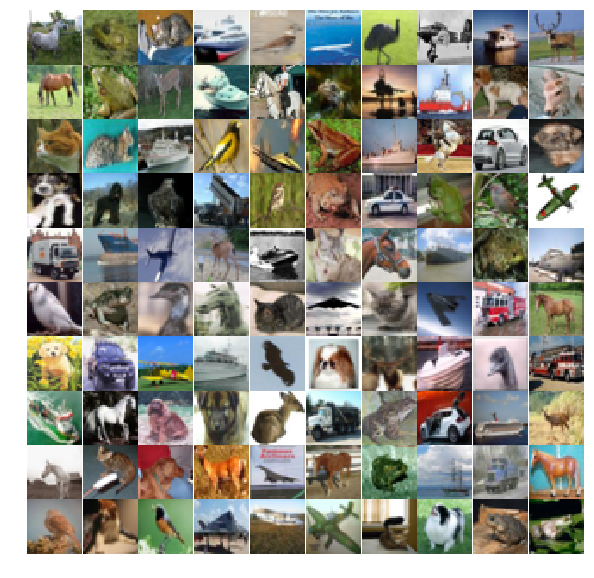

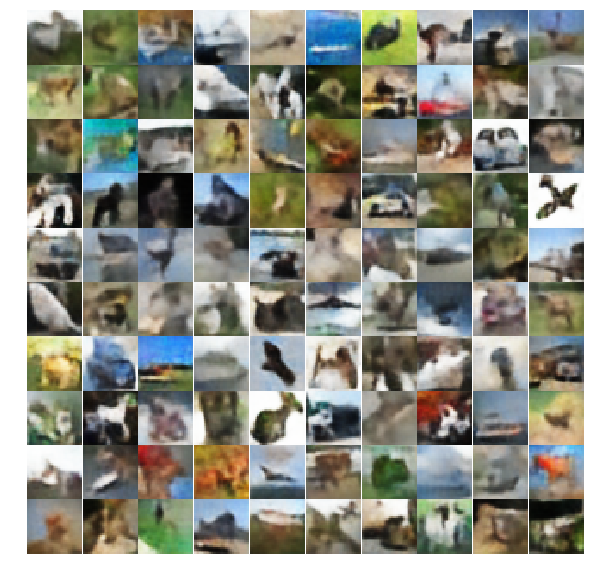

In [2]:
valid_origin = sess.run(valid_images)
valid_recons = sess.run(net.p_x_z,feed_dict={x:valid_origin})
draw(valid_origin)
draw(valid_recons)

## CIFAR 10 Reconstruction - Training Set

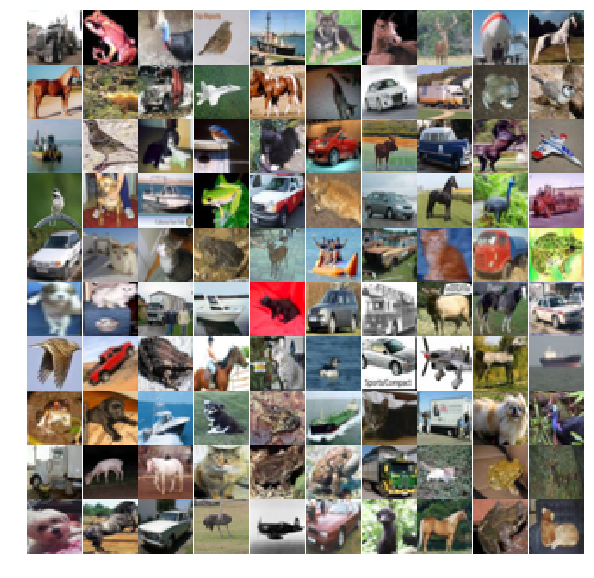

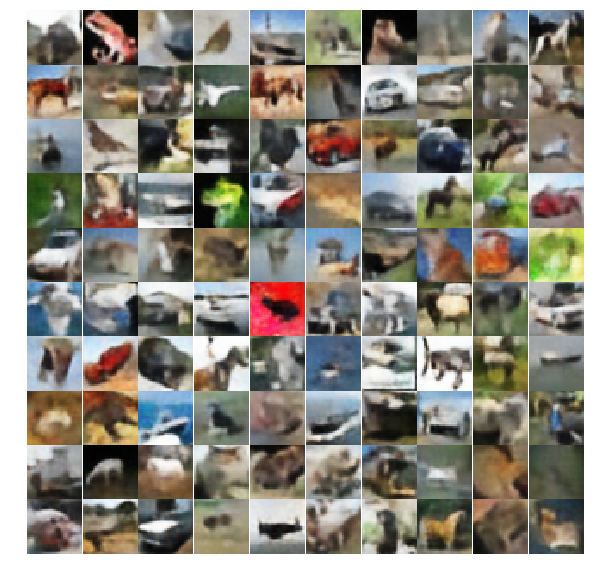

In [3]:
origin = sess.run(images )
recons = sess.run(net.p_x_z,feed_dict={x:origin})
draw(origin)
draw(recons)

## Sampled Cifar10 (Class Conditioned)

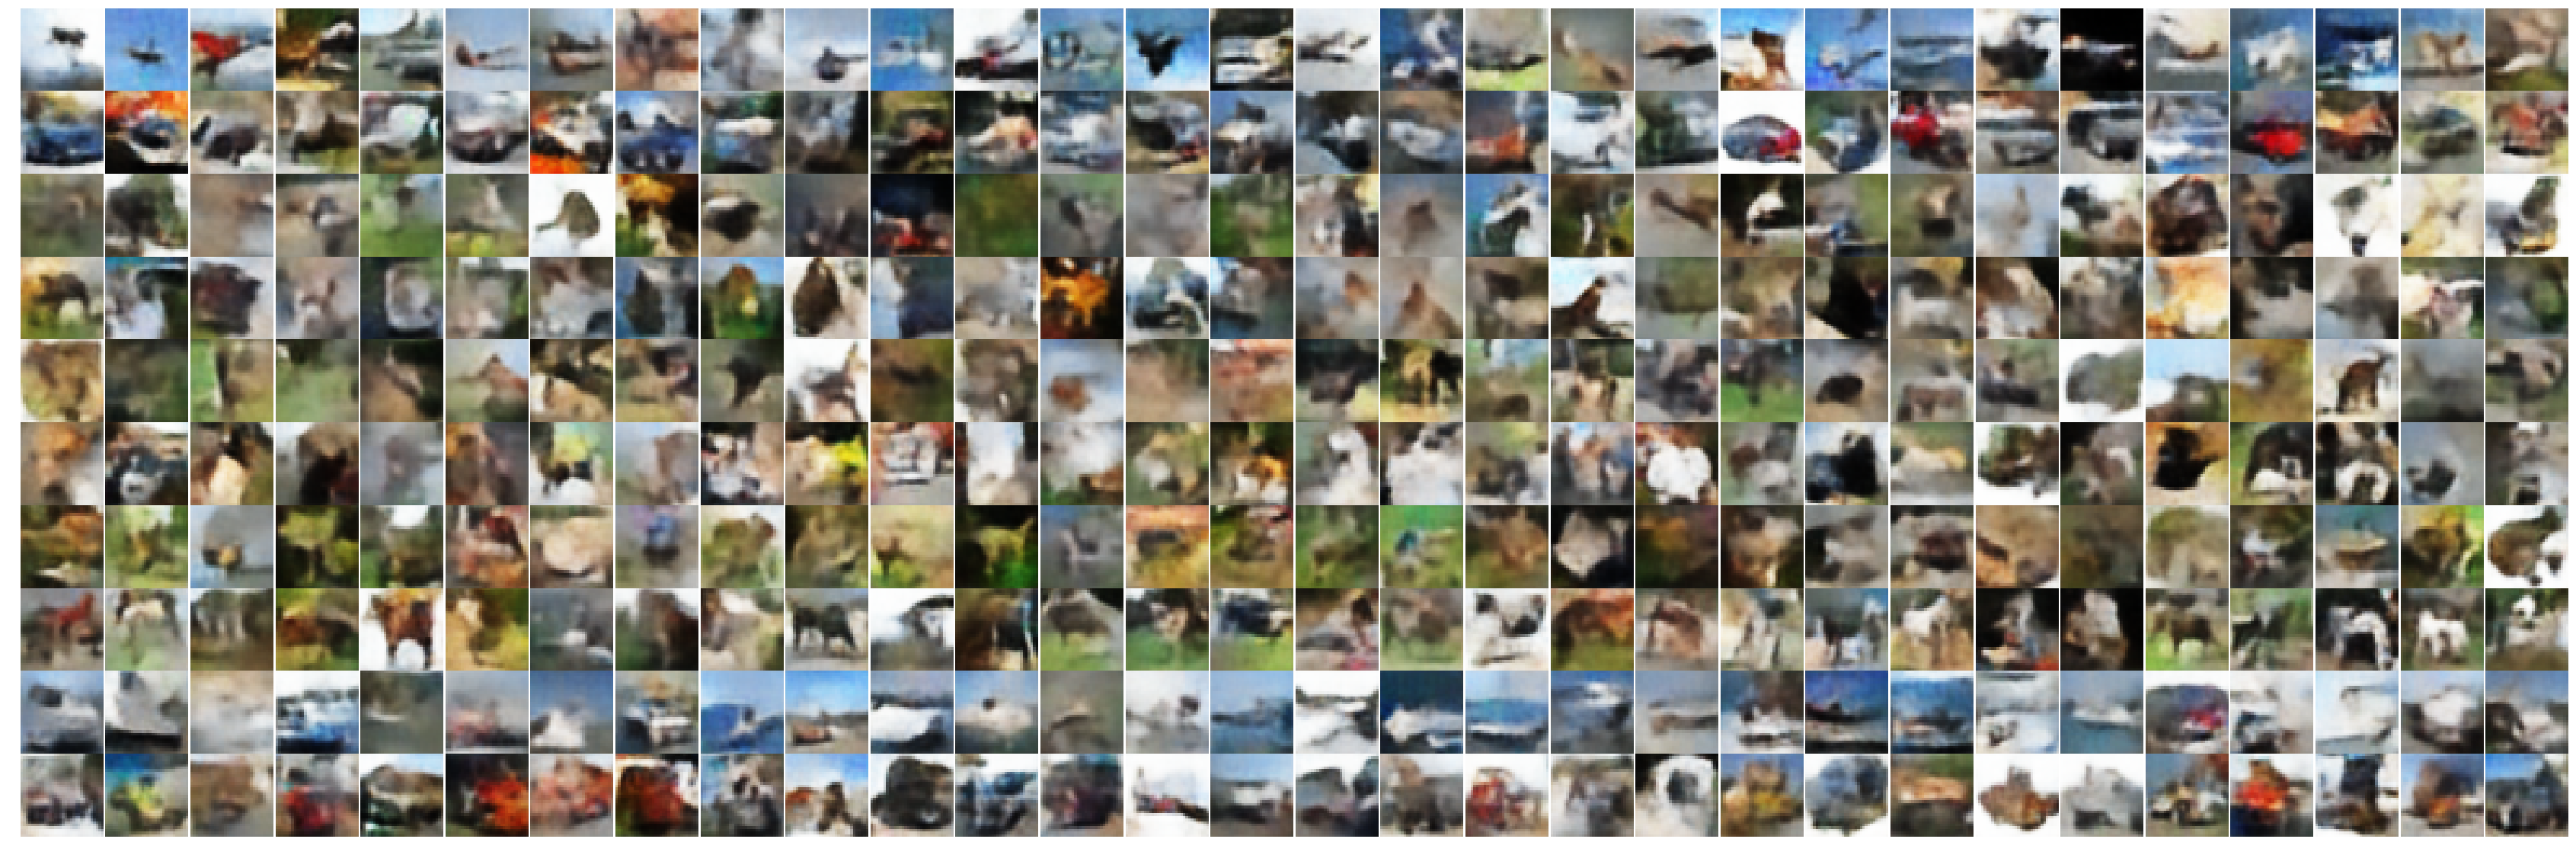

In [8]:
def draw(images):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(60,20))
    for n, image in enumerate(images):
        a = fig.add_subplot(10, 30, n + 1)
        a.imshow( np.squeeze((image*255.0)).astype(np.uint8), cmap='gray' )
        a.axis('off')
        a.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

sampled_zs,log_probs = pixelcnn_net.sample_from_prior(sess,np.arange(10),30)
sampled_ims = sess.run(net.gen,feed_dict={net.latent:sampled_zs})
draw(sampled_ims)